In [334]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [335]:
#Instal new version of Tensorflow
#!pip3 install --upgrade tensorflow==2.12.0

In [336]:
import random
from datetime import datetime
import time
import resource
import pickle
import os
import pdb


import numpy as np
import pandas as pd
import keras
from scipy.interpolate import pchip_interpolate

import tensorflow as tf
#import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
#In old version of Tensorflow 2.8.0
#from tensorflow.keras.optimizers import Adam
#In new version of Tensorflow 2.12.0, please use legacy to import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
#from keras import backend as K

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import clear_output, display, HTML

from matplotlib import pyplot as plt
import seaborn as sns

# originally built on old TensorFlow and Keras which didn't support eager execution
tf.compat.v1.disable_eager_execution()
#tf.compat.v1.disable_v2_behavior()
#tf.compat.v1.enable_eager_execution()

# set seeds for reproducibility
# np.random.uniform(0,10000) 4465
random.seed(4465)
np.random.seed(4465)
tf.random.set_seed(4465)

print("TensorFlow %s" % tf.__version__)
print("Keras %s" % keras.__version__)
print("plotly %s" % plotly.__version__)
print("pandas %s" % pd.__version__)
print("numpy %s" % np.__version__)

# If model save directory isn't made yet, make it
if not os.path.exists('model_output'):
    os.makedirs('model_output')
if not os.path.exists('model_output/trading'):
    os.makedirs('model_output/trading')

TensorFlow 2.12.0
Keras 2.12.0
plotly 5.15.0
pandas 2.0.3
numpy 1.23.5


In [337]:
def sizeof_fmt(num, suffix='B'):
    """given memory as int format as memory units eg KB"""
    for unit in ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Y', suffix)

def memusage():
    """print memory usage"""
    return sizeof_fmt(int(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))

memusage()

'3.8 MB'

In [338]:
def make_figure(*series, title="", xtitle="", ytitle=""):
    fig = go.Figure()
    series=list(series)
    x = series.pop(0)
    for s in series:
        fig.add_trace(go.Scatter(y=s, x=x))
    fig.update_layout(
        title= dict(text=title,
                    x=0.5,
                    xanchor='center'),
        xaxis=dict(
            title=xtitle,
            linecolor='black',
            linewidth=1,
            mirror=True
        ),
        yaxis=dict(
            title=ytitle,
            linecolor='black',
            linewidth=1,
            mirror=True
        ),
        showlegend=False
    )

    return fig.show()

In [339]:
stock_series = []
prob_memory = []

amplifier=1000
date=478
stock=46
#be cautious when setting dt. dt is inverse proportional to learning time dt=1 means no optimization
dt=1

#filename="IndexWap_day231.csv"
#excelfilereader=pd.read_csv(r'/content/kaggle_optiver_data/IndexWap_day231.csv', header=None)
#data = excelfilereader.iloc[0,:].values.tolist()
#data = excelfilereader.iloc[0,:]*1000

#excelfilereader=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/train.csv')

excelfilereader=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')

def Data_input(test,stock,date,amplifier,dt=1):
    data_sub=test[test['stock_id']==stock]
    data_sub2=data_sub[data_sub['date_id']==date]
    data=pd.DataFrame(data_sub2,columns=['wap'])
    data = data.values.tolist()
    data=np.squeeze(data)
    data=data*amplifier
    stock_series=data
    time_series=range(0,data.shape[0])
    df = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})
    x=df['dateindex']
    y=df['stock']
    x_sub = np.linspace(min(x), max(x), num=int(df.shape[0]/dt))
    y_sub = pchip_interpolate(x, y, x_sub)
    df_new = pd.DataFrame({'dateindex': x_sub, 'stock': y_sub})
    return df_new

df_new=Data_input(excelfilereader,stock,date,amplifier)

make_figure(df_new['dateindex'], df_new['stock'],
            title="Stock {} price at date {}".format(int(stock), int(date)),
            xtitle='Timesteps',
            ytitle='Value'
           )


In [340]:
index_1=[0,6,12,18,24,30,36,42,48,54]
index_2=[1,7,13,19,25,31,37,43,49]
index_3=[2,8,14,20,26,32,38,44,50]
index_4=[3,9,15,21,27,33,39,45,51]
index_5=[4,10,16,22,28,34,40,46,52]
index_6=[5,11,17,23,29,35,41,47,53]
index_list=[index_1,index_2,index_3,index_4,index_5, index_6]


In [341]:
def indexWAP(data, date, t):
    coefficient = [0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.002,
                   0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004, 0.002, 0.002, 0.004, 0.002,
                   0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004, 0.004, 0.004, 0.006, 0.002, 0.002, 0.04,
                   0.002, 0.002, 0.004, 0.04, 0.002, 0.001, 0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002,
                   0.006, 0.004, 0.006, 0.004, 0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004,
                   0.002, 0.004, 0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
                   0.02, 0.004, 0.006, 0.002, 0.02, 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02, 0.006, 0.001, 0.002,
                   0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002, 0.004, 0.006, 0.006, 0.001, 0.04,
                   0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002, 0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008,
                   0.006, 0.004, 0.002, 0.006, 0.002, 0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008,
                   0.006, 0.008, 0.002, 0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001,
                   0.002, 0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002, 0.04,
                   0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02, 0.004, 0.002, 0.006, 0.02, 0.001, 0.002, 0.006,
                   0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04, 0.002, 0.008, 0.002, 0.004, 0.001,
                   0.004, 0.006, 0.004]
    date_sub = data.loc[(data["date_id"] == date) & (data["seconds_in_bucket"] == t)]
    stk_id = pd.DataFrame(date_sub, columns=["stock_id"])
    wap = pd.DataFrame(date_sub, columns=["wap"])
    stk_id_arr = np.array(stk_id).reshape(-1)

    missing_elemnts = [item for item in range(stk_id_arr[0], 200) if item not in stk_id_arr]
    missing_elemnts_arr = np.array(missing_elemnts).reshape(-1)
    list_coefficient = coefficient
    for i in sorted(missing_elemnts_arr, reverse=True):
        list_coefficient.pop(i)

    norm = [float(i) / sum(list_coefficient) for i in list_coefficient]
    stock_index = np.dot(norm, wap)
    return (np.array([stock_index]).item())


In [342]:
def Index_Calc(test,date):
    time_arr = np.arange(0, 550, 10)
    date_0 = test.loc[(test["date_id"] == date)]

    index = []

    for i in time_arr:
        index.append(indexWAP(date_0, date, i))
    index=np.squeeze(index)
    index=index*amplifier
    df_index = pd.DataFrame({'dateindex': x_sub, 'stock': index})
    return df_index

#df_index=Index_Calc(date)
#make_figure(df_index['dateindex'], df_index['stock'],
#            title="Index at date {}".format(int(date)),
#            xtitle='Timesteps',
#            ytitle='Value'
#           )


In [343]:
def user_gen(df,start_trend=amplifier):
    t=0
    trend_index = start_trend
    while t<=(df.shape[0]):
        stock_price= df['stock'][t]
        yield(t, stock_price, trend_index)
        t+=1

def user_gen_dt(df,dt=1,start_trend=amplifier):
    t=0
    trend_index = start_trend
    x=df['dateindex']
    y=df['stock']
    x_sub = np.linspace(min(x), max(x), num=int(df.shape[0]/dt))
  #print(np.shape(x_sub))
    y_sub = pchip_interpolate(x, y, x_sub)
  #print(np.shape(y_sub))
    while t<=int(len(x_sub)/dt):
        stock_price= y_sub[t]
        yield(t, stock_price, trend_index)
        t+=dt

def user_sub(df,index_sub,start_trend=amplifier):
    t=0
    trend_index = start_trend
    x=range(len(index_sub))
    y=[]
    #x=df['dateindex'][index_sub]
    y=df['stock'][index_sub]
    for i in range(len(index_sub)):
        y[i]=df['stock'][index_sub[i]]
    while t<=int(len(x)):
        stock_price= y[t]
        yield(t, stock_price, trend_index)
        t+=1

In [344]:
def market_gen(gen, lag=1):

    buffer = []
    diffbuffer = []


    # fill buffer
    dt, last, trend = next(gen)
    for i in range(lag):
        prev = last
        dt, last, trend = next(gen)
        buffer.append(last-trend)
        diffbuffer.append(last-prev)

    # yield first group of lag vals and diffs
    yield buffer+diffbuffer

    while(True):
        prev = last
        dt, last, trend = next(gen)
        buffer.pop(0)
        buffer.append(last-trend)
        diffbuffer.pop(0)
        diffbuffer.append(last-prev)
        yield buffer+diffbuffer



In [345]:
class Market:
    """Follows OpenAI gym environment convention basically
    init with generator and number of stocks
    reset() - generate and return first state
    step() - generate next state and reward
    """
    def __init__(self, gen, lag=16, nstocks=1, episode_length=300):
        self.genfunc = gen
        self.nstocks = nstocks
        self.episode_length = episode_length
        self.t = 0
        self.total_reward = 0
        self.lag = lag
        self.observation_space = np.asarray([1] * nstocks * lag * 2,)
        self.state_size = nstocks * lag * 2
        self.action_size = 2

    def reset(self):
        self.t = 0
        self.total_reward = 0
        self.gen = [self.genfunc() for _ in range(self.nstocks)]
        self.state=[next(g) for g in self.gen]
        self.state = np.asarray([s for s in self.state])
        return self.state

    def render(self):
        print(self.state[0, nstocks-1])

    def step(self, action):
        action = np.asarray([action])
        try:
            self.state=[next(g) for g in self.gen]
        except StopIteration:
            return print("generator failed.\n")
        
        self.state = np.asarray([s for s in self.state])
        # last element is most recent change
        stock_delta = np.asarray([s[-1] for s in self.state])
        # element at lag-1 is most recent deviation
        market_price = np.asarray([s[self.lag-1]+100 for s in self.state])
        # map actions 0 1 2 to positions -1, 0, 1
        position = action - 1
        reward = position @ stock_delta
        self.total_reward += reward
        self.t += 1
        done = True if self.episode_length and self.t >= self.episode_length else False
        # state, reward, done, info
        return self.state, reward, done, market_price

    def close(self):
        pass


#env = Market(user_gen_dt(df,0.1), lag=1, nstocks=1, episode_length=10)

In [346]:
DISCOUNT_RATE = 0
# WIN_REWARD = 10
EPSILON_DECAY = 0.995
SAMPLE_SIZE = 256
RENDER = False
OUTPUT_DIR = 'model_output/trading/'

class DQN_Agent:
    def __init__(self, state_size, action_size, filename="dqn",
                 discount_rate=DISCOUNT_RATE,
                 learning_rate=0.001,
                 epsilon=1.0,
                 epsilon_decay=EPSILON_DECAY,
                 epsilon_min=0.01):

        self.state_size = state_size
        self.action_size = action_size
        self.filename = filename
        self.discount_rate = discount_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate

        self.model = self.build_model()
        self.memory = pd.DataFrame(columns=["state", "action", "next_state",
                                            "reward", "done"])
        self.memory_size = 100000
        self.results = []
        self.train_batch_size = 1
        self.timestep = 0
        self.save_interval = 10

    def build_model(self,
                    n_hidden_layers=2,
                    hidden_layer_size=16,
                    activation='relu',
                    reg_penalty=0.001,
                    dropout=0.0675,
                    verbose=True
                   ):
        """return keras NN model per inputs
        input is a state - array of size state_size
        output is an array of action values - array of size action_size
        """

        inputs = Input(shape=(self.state_size,), name="Input")
        last_layer = inputs

        for i in range(n_hidden_layers):
            if verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   hidden_layer_size,
                                   activation,
                                   reg_penalty,
                                   dropout))
            # add dropout, but not on inputs, only between hidden layers
            if i and dropout:
                last_layer = Dropout(dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=hidden_layer_size,
                               activation=activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=l2(reg_penalty),
                               name="Dense%02d" % i)(last_layer)

        outputs = Dense(self.action_size, activation='linear', name="Output")(last_layer)

        #model = Model(inputs=input_layer , output=last_layer)
        model = Model(inputs=inputs, outputs=outputs)

        if verbose:
            print(model.summary())

        model.compile(loss='mse', optimizer=Adam(
            #learning_rate=self.learning_rate
        ))

        return model

    def remember(self):
        """store the states and rewards needed to fit the model"""
        # append in place
        self.memory.loc[self.memory.shape[0]] = [self.state,
                                                 self.action,
                                                 self.next_state,
                                                 self.reward,
                                                 self.done]

    def train(self):
        """train the model on experience stored by remember"""

        # need at least SAMPLE_SIZE observations
        if self.memory.shape[0] < SAMPLE_SIZE:
            return

        # truncate memory
        self.memory = self.memory[-self.memory_size:]
        # sample sample_size observations from memory
        minibatch = self.memory.sample(n=SAMPLE_SIZE)

        # target is our best estimate of value of each action
        X_fit = np.concatenate(minibatch['state'].values)
        X_fit = X_fit.reshape((SAMPLE_SIZE, self.state_size))
        Y_pred = self.model.predict(X_fit)

        # we don't just fit model against model's own prediction, gets us nowhere
        # we improve the target by what we learned about the action we actually took
        # value is reward obtained + predicted value of the observed next state
        minibatch['target_observed'] = minibatch['reward']
        # if done, target is the reward
        # reward by gym env is only 1 for each timestep of survival
        # but we also added a reward of -10 on failure
        # if not done, add discount_rate  * Q-value prediction for  observed next state
        not_done = minibatch.loc[minibatch['done'] == False]
        X_observed = np.concatenate(not_done['next_state'].values)
        X_observed = X_observed.reshape((not_done.shape[0], self.state_size))
        # run all predictions at once
        # iterates faster but does not train after each prediction
        y_observed_pred = np.amax(self.model.predict(X_observed), axis=1)
        minibatch.loc[minibatch['done'] == False, 'target_observed'] \
            += self.discount_rate * y_observed_pred
        # vectorized vlookup - update col specified by action with target_observed
        np.put_along_axis(Y_pred,
                          minibatch['action'].astype(int).values.reshape(SAMPLE_SIZE, 1),
                          minibatch['target_observed'].values.reshape(SAMPLE_SIZE, 1),
                          axis=1)
        # fit model against improved target
        # arbitrary 8 batch size to reduce variance a little and speed up fit
        self.model.fit(X_fit, Y_pred,
                       epochs=1,
                       batch_size=self.train_batch_size,
                       verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        """pick an action using model"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def save(self):
        "save agent: pickle self and use Keras native save model"
        fullname = "%s%s%05d" % (OUTPUT_DIR, self.filename, len(self.results))
        self.model.save("%s.h5" % fullname)
        pickle.dump(self, open("%s.p" % fullname, "wb"))

    def load(filename):
        "load saved agent"
        new = pickle.load(open("%s.p" % filename, "rb"))
        new.model = load_model("%s.h5" % filename)
        print("loaded %d results, %d rows of memory, epsilon %.4f" % (len(new.results),
                                                                      len(new.memory),
                                                                      new.epsilon))
        return new

    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        self.total_reward = 0

    def increment_time(self):
        """increment timestep counter"""
        self.timestep += 1

    def save_score(self):
        """save score of each episode"""
        self.results.append(self.total_reward)

    def score_episode(self, episode_num, n_episodes):
        """output results and save"""
        self.save_score()
        avglen = min(len(self.results), self.save_interval)
        formatstr = "{} episode {}/{}:, score: {}, {}-episode avg: {:.1f} Memory: {}        "
        print(formatstr.format(time.strftime("%H:%M:%S"), len(self.results),
                               n_episodes, self.total_reward, avglen,
                               sum(self.results[-avglen:])/avglen, memusage()),
              end="\r", flush=False)

    def run_episode(self, render=RENDER):
        """run a full episode"""
        global env

        self.reset()
        self.state = env.reset()
        self.done = False

        while not self.done:
            if render:
                env.render()
            self.action = self.act(self.state.reshape([1, self.state_size]))
            self.next_state, self.reward, self.done, _ = env.step(self.action)
            self.total_reward += self.reward
            self.remember()
            self.state = self.next_state
            self.increment_time()

        if render:
            env.render()

        self.train()

    def rlplot(self, title='Agent Training Progress'):
        """plot training progress"""
        df = pd.DataFrame({'timesteps': self.results})
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward per Episode",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()


In [347]:
RENDER = False
OUTPUT_DIR = 'model_output/trading/'

class Agent:
    """abstract base class for agents"""

    def __init__(self, state_size, action_size, filename="model",
                 *args, **kwargs):
        self.state_size = state_size
        self.action_size = action_size
        self.filename = filename
        self.timestep = 0
        self.total_reward = 0
        self.save_interval = 10

        raise NotImplementedError

    def build_model(self, *args, **kwargs):
        """build the relevant model"""
        raise NotImplementedError

    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        self.total_reward = 0

    def increment_time(self):
        """increment timestep counter"""
        self.timestep += 1

    def remember(self, *args, **kwargs):
        """store the states and rewards needed to fit the model"""
        raise NotImplementedError

    def train(self, *args, **kwargs):
        """train the model on experience stored by remember"""
        raise NotImplementedError

    def act(self, *args, **kwargs):
        """pick an action using model"""
        raise NotImplementedError

    def save_score(self):
        """save score of each episode"""
        self.results.append(self.total_reward)

    def score_episode(self, episode_num, n_episodes):
        """output results and save"""
        self.save_score()
        avglen = min(len(self.results), self.save_interval)
        formatstr = "{} episode {}/{}:, score: {}, {}-episode avg: {:.1f} Memory: {}        "
        print(formatstr.format(time.strftime("%H:%M:%S"), len(self.results),
                               n_episodes, self.total_reward, avglen,
                               sum(self.results[-avglen:])/avglen, memusage()),
              end="\r", flush=False)

    def run_episode(self, render=RENDER):
        """run a full episode"""
        global env

        self.reset()
        self.state = env.reset()
        self.done = False

        while not self.done:
            if render:
                env.render()
            self.action = self.act(self.state.reshape([1, self.state_size]))
            self.next_state, self.reward, self.done, _ = env.step(self.action)
            self.total_reward += self.reward

            self.remember()
            self.state = self.next_state
            self.increment_time()

        if render:
            env.render()

        self.train()

    def save(self, *args, **kwargs):
        """save agent to disk"""
        raise NotImplementedError

    def load(*args, **kwargs):
        """load agent from disk"""
        raise NotImplementedError

    def view(self):
        """Run an episode without training, with rendering"""
        state = env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False

        # run an episode
        self.timestep = 0
        r = 0
        while not done:
            env.render()
            action = self.act(state)
            lastmarket = self.state[0, nstocks-1]
            state, reward, done, _ = env.step(action)
            newmarket = self.state[0, nstocks-1]
            print("prev mkt: %.4f action: %d, new mkt %f, reward %f" % (lastmarket, action, newmarket, reward))
            r += reward
            state = np.reshape(state, [1, self.state_size])
            self.timestep += 1
        env.render()
        print(r)
        env.close()
        return self.timestep

    def rlplot(self, title='Trading Agent Training Progress'):
        """plot training progress"""
        df = pd.DataFrame({'timesteps': self.results})
        df['avg'] = df['timesteps'].rolling(10).mean()

        fig = go.Figure()
        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['timesteps'],
                                 mode='markers',
                                 name='timesteps',
                                 marker=dict(
                                     color='mediumblue',
                                     size=4,
                                 ),
                                ))

        fig.add_trace(go.Scatter(x=df.index,
                                 y=df['avg'],
                                 mode='lines',
                                 line_width=3,
                                 name='moving average'))

        fig.update_layout(
            title=dict(text=title,
                       x=0.5,
                       xanchor='center'),
            xaxis=dict(
                title="Episodes",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            yaxis=dict(
                title="Total Reward per Episode",
                linecolor='black',
                linewidth=1,
                mirror=True
            ),
            legend=go.layout.Legend(
                x=0.01,
                y=0.99,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
                #bgcolor="LightSteelBlue",
                bordercolor="Black",
                borderwidth=1,
            ),
        )

        return fig.show()


In [348]:
class REINFORCE_Agent(Agent):
    """REINFORCE policy gradient method using deep Keras NN"""
    def __init__(self, state_size=4, action_size=2, learning_rate=0.005,
                 discount_rate=DISCOUNT_RATE, n_hidden_layers=2, hidden_layer_size=16,
                 activation='relu', reg_penalty=0, dropout=0, filename="kreinforce",
                 verbose=True):
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = list(range(action_size))
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate

        self.n_hidden_layers = n_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.activation = activation
        self.reg_penalty = reg_penalty
        self.dropout = dropout
        self.verbose = verbose
        self.filename = filename

        self.train_model, self.predict_model = self.policy_model()
        self.results = []
        self.save_interval = 10
        self.reset()


    def reset(self):
        """reset agent for start of episode"""
        self.timestep = 0
        # truncate memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.total_reward = 0

    def policy_model(self):
        """set up NN model for policy.
        predict returns probs of actions to sample from.
        train needs discounted rewards for the episode, so we define custom loss.
        when training use train_model with custom loss and multi input of training data and rewards.
        when predicting use predict_model with single input.
        """

        def custom_loss(y_true, y_pred):
            y_pred_clip = K.clip(y_pred, 1e-8, 1-1e-8)
            log_likelihood = y_true*K.log(y_pred_clip)
            return K.sum(-log_likelihood*discounted_rewards)

        inputs = Input(shape=(self.state_size,), name="Input")
        discounted_rewards = Input(shape=(1,), name="Discounted_rewards")
        last_layer = inputs

        for i in range(self.n_hidden_layers):
            if self.verbose:
                formatstr = "layer %d size %d, %s, reg_penalty %.8f, dropout %.3f"
                print(formatstr % (i + 1,
                                   self.hidden_layer_size,
                                   self.activation,
                                   self.reg_penalty,
                                   self.dropout,
                                   ))
            # add dropout, but not on inputs, only between hidden layers
            if i and self.dropout:
                last_layer = Dropout(self.dropout, name="Dropout%02d" % i)(last_layer)

            last_layer = Dense(units=self.hidden_layer_size,
                               activation=self.activation,
                               kernel_initializer=glorot_uniform(),
                               kernel_regularizer=keras.regularizers.l2(self.reg_penalty),
                               name="Dense%02d" % i)(last_layer)

        outputs = Dense(self.action_size, activation='softmax', name="Output")(last_layer)

        train_model = Model(inputs=[inputs, discounted_rewards], outputs=[outputs])
        train_model.compile(optimizer=Adam(lr=self.learning_rate), loss=custom_loss)

        predict_model = Model(inputs=[inputs], outputs=[outputs])

        if self.verbose:
            print(predict_model.summary())

        return train_model, predict_model


    def act(self, state):
        """pick an action using predict_model"""
        probabilities = self.predict_model.predict(state)

        action = np.random.choice(self.action_space, p=probabilities[0])
        prob=probabilities[0][action]
        #print("probability={}\n".format(probabilities[0][action]))
        prob_memory.append(prob)
        return action

    def remember(self):
        """at each step save state, action, reward for future training"""

        self.state_memory.append(self.state)
        self.action_memory.append(self.action)
        self.reward_memory.append(self.reward)
        

    def train(self):
        """train the model on experience stored by remember"""
        state_memory = np.array(self.state_memory)
        state_memory = state_memory.reshape((len(self.state_memory),self.state_size))
        action_memory = np.array(self.action_memory)
        reward_memory = np.array(self.reward_memory)

        # one-hot actions
        actions = np.zeros([len(action_memory), self.action_size])
        actions[np.arange(len(action_memory)), action_memory] = 1

        disc_rewards = np.zeros_like(reward_memory)
        cumulative_rewards = 0
        for i in reversed(range(len(reward_memory))):
            cumulative_rewards = cumulative_rewards * self.discount_rate + reward_memory[i]
            disc_rewards[i] = cumulative_rewards

        # standardize
        disc_rewards -= np.mean(disc_rewards)
        disc_rewards /= np.std(disc_rewards) if np.std(disc_rewards) > 0 else 1

        # train states v. actions, (complemented by disc_rewards_std)
        cost = self.train_model.train_on_batch([state_memory, disc_rewards], actions)

        return cost

    def view(self):
        """Run an episode without training, with rendering"""
        state = env.reset()
        state = np.reshape(state, [1, self.state_size])
        done = False

        # run an episode
        self.timestep = 0
        r = 0
        retarray = []
        while not done:
            action = self.act(state)
            lastmarket = state[0, self.state_size//2-1]
            state, reward, done, _ = env.step(action)
            newmarket = state[0, self.state_size//2-1]
            print("prev mkt: %.4f action: %d, new mkt %.4f, reward %f" % (lastmarket, action, newmarket, reward))
            r += reward
            state = np.reshape(state, [1, self.state_size])
            self.timestep += 1
            retarray.append((self.timestep, action, lastmarket, newmarket, reward))
        print(r)
        env.close()
        return retarray

    def save(self):
        "save agent: pickle self and use Keras native save model"
        fullname = "%s%s%05d" % (OUTPUT_DIR, self.filename, len(self.results))
        self.predict_model.save("%s_predict.h5" % fullname)
        # can't save / load train model due to custom loss
        pickle.dump(self, open("%s.p" % fullname, "wb"))

    def load(filename, memory=True):
        "load saved agent"
        self = pickle.load(open("%s.p" % filename, "rb"))
        self.predict_model = load_model("%s_predict.h5" % filename)
        print("loaded %d results, %d rows of memory, epsilon %.4f" % (len(self.results),
                                                                      len(self.memory),
                                                                      self.epsilon))

In [349]:
#dt=1
#index_1=[0,6,12,18,24,30,36,42,48,54]
#index_2=[1,7,13,19,25,31,37,43,49]
#index_3=[2,8,14,20,26,32,38,44,50]
#index_4=[3,9,15,21,27,33,39,45,51]
#index_5=[4,10,16,22,28,34,40,46,52]
#index_6=[5,11,17,23,29,35,41,47,53]

#index_pick=index_5
N_EPISODES = 500
#lag is fixed
lag = 1
#ticks_per_episode = len(index_pick)/dt-1-lag
nstocks = 1


#gen = user_sub(df_new,index_1,start_trend=amplifier)


In [350]:
#def shm_market_gen():
#    return market_gen(gen=user_sub(df_new,index_pick,start_trend=amplifier),
#                      lag=lag)


#gen=shm_market_gen()
#time_series=[]
#stock_series=[]
#for i in range(len(index_pick)-lag):
#    z = next(gen)
#    time_series.append(i)
#    stock_series.append(z[1])

#df_gen = pd.DataFrame({'dateindex': time_series, 'stock': stock_series})

#make_figure(df_gen['dateindex'], df_gen['stock'],
#            title='Genarated market',
#            xtitle='Timesteps',
#            ytitle='buffer+diffbuffer'
#           )

In [351]:
    result_index=[]
    df_index=Index_Calc(excelfilereader,date)
    for i in range(len(index_list)):
        ticks_per_episode = len(index_list[i])/dt-1-lag
        def shm_market_gen():
            return market_gen(gen=user_sub(df_index,index_list[i],start_trend=amplifier),lag=1)
        env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

        agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

        start_time = time.time()
        print("Start: %s" % (time.strftime("%H:%M:%S")))

        for e in range(N_EPISODES):
            agent.run_episode()
            agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

        elapsed_time = time.time() - start_time
        print("\nTrain time: ", elapsed_time)
        env.reset()
        z = agent.view()

        df = pd.DataFrame(z)
        df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
        df['lastmarket']+=1
        df['newmarket']+=1
        df['short'] = np.nan
        df.loc[df['action']==0, 'short'] = df['newmarket']
        df['flat'] = np.nan
        df.loc[df['action']==1, 'flat'] = df['newmarket']
        df['long'] = np.nan
        df.loc[df['action']==2, 'long'] = df['newmarket']
        df['totalreward'] = df['reward'].cumsum()
        df.to_csv('df_index_list_{}.csv'.format(i))
        prob=agent.predict_model.predict(agent.state_memory)
        action = np.random.choice(agent.action_space, p=prob[0])
        arr=np.array(df_index['stock'][index_list[i]])
        mean_diff=np.mean(np.absolute(np.diff(arr)))
        action_arr=np.array(df['action']-1)
        pick_index=np.array(df_index['stock'][index_list[i]])
        wap_future_index=[]
    #assume in the first time index of t+60 the same as t
        wap_future_index.append(pick_index[0])
        for j in range(len(action_arr)):
            wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
        wap_future_index.append((action-1)*mean_diff+pick_index[-1])
        seconds_in_bucket=[j * 10 for j in index_list[i]]
        comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
        result_index.append(comb)

    



layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_249"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Start: 21:16:47


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



21:17:12 episode 500/500:, score: 2.4154080000004114, 10-episode avg: 2.3 Memory: 3.8 MB           
Train time:  24.909185647964478
prev mkt: 1.0869 action: 2, new mkt 1.3753, reward 0.288445
prev mkt: 1.3753 action: 0, new mkt 0.7831, reward 0.592189
prev mkt: 0.7831 action: 2, new mkt 1.1325, reward 0.349364
prev mkt: 1.1325 action: 0, new mkt 0.4120, reward 0.720463
prev mkt: 0.4120 action: 2, new mkt 0.4070, reward -0.005050
prev mkt: 0.4070 action: 2, new mkt 0.8868, reward 0.479815
prev mkt: 0.8868 action: 2, new mkt 1.1438, reward 0.256987
prev mkt: 1.1438 action: 0, new mkt 1.4106, reward -0.266805
2.4154080000004114
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_251"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                            

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



21:17:35 episode 500/500:, score: 2.389495999999781, 10-episode avg: 1.9 Memory: 3.8 MB           
Train time:  22.931459188461304
prev mkt: 1.4387 action: 2, new mkt 1.4476, reward 0.008884
prev mkt: 1.4476 action: 0, new mkt 0.9719, reward 0.475623
prev mkt: 0.9719 action: 2, new mkt 1.0910, reward 0.119049
prev mkt: 1.0910 action: 0, new mkt 0.2583, reward 0.832733
prev mkt: 0.2583 action: 2, new mkt 0.6808, reward 0.422542
prev mkt: 0.6808 action: 2, new mkt 1.0839, reward 0.403097
prev mkt: 1.0839 action: 2, new mkt 1.2115, reward 0.127568
2.389495999999781
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



21:17:58 episode 500/500:, score: 2.3563709999992852, 10-episode avg: 2.3 Memory: 3.8 MB         
Train time:  23.036609411239624
prev mkt: 1.6056 action: 0, new mkt 1.4413, reward 0.164294
prev mkt: 1.4413 action: 0, new mkt 0.9639, reward 0.477411
prev mkt: 0.9639 action: 0, new mkt 0.9588, reward 0.005050
prev mkt: 0.9588 action: 0, new mkt 0.1924, reward 0.766411
prev mkt: 0.1924 action: 2, new mkt 0.6607, reward 0.468280
prev mkt: 0.6607 action: 2, new mkt 1.1868, reward 0.526152
prev mkt: 1.1868 action: 0, new mkt 1.2381, reward -0.051227
2.3563709999992852
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_255"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)         

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



21:18:22 episode 500/500:, score: 1.6667510000003176, 10-episode avg: 2.3 Memory: 3.8 MB          
Train time:  23.65687870979309
prev mkt: 1.5710 action: 0, new mkt 1.2090, reward 0.361997
prev mkt: 1.2090 action: 0, new mkt 1.1077, reward 0.101355
prev mkt: 1.1077 action: 0, new mkt 0.9792, reward 0.128499
prev mkt: 0.9792 action: 0, new mkt 0.2306, reward 0.748599
prev mkt: 0.2306 action: 2, new mkt 0.7184, reward 0.487778
prev mkt: 0.7184 action: 2, new mkt 1.1566, reward 0.438236
prev mkt: 1.1566 action: 2, new mkt 1.2809, reward 0.124281
2.3907449999998107
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_257"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)          

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 21:18:22
21:18:46 episode 500/500:, score: 1.7486610000004248, 10-episode avg: 1.8 Memory: 3.8 MB           
Train time:  23.84268546104431
prev mkt: 1.2884 action: 0, new mkt 0.7006, reward 0.587806
prev mkt: 0.7006 action: 2, new mkt 1.1016, reward 0.401022
prev mkt: 1.1016 action: 2, new mkt 0.9944, reward -0.107207
prev mkt: 0.9944 action: 0, new mkt 0.5570, reward 0.437407
prev mkt: 0.5570 action: 2, new mkt 0.6872, reward 0.130228
prev mkt: 0.6872 action: 2, new mkt 1.0677, reward 0.380528
prev mkt: 1.0677 action: 2, new mkt 1.3633, reward 0.295537
2.125321000000099
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_259"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Den

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 21:18:46
21:19:10 episode 500/500:, score: 1.573694999999816, 10-episode avg: 1.6 Memory: 3.8 MB           
Train time:  23.889973640441895
prev mkt: 1.2153 action: 0, new mkt 0.6253, reward 0.590052
prev mkt: 0.6253 action: 2, new mkt 1.1916, reward 0.566294
prev mkt: 1.1916 action: 0, new mkt 1.0193, reward 0.172283
prev mkt: 1.0193 action: 0, new mkt 0.4650, reward 0.554270
prev mkt: 0.4650 action: 2, new mkt 0.7779, reward 0.312851
prev mkt: 0.7779 action: 0, new mkt 1.1098, reward -0.331877
prev mkt: 1.1098 action: 0, new mkt 1.3999, reward -0.290178
1.573694999999816


In [352]:
from itertools import chain

result_indx_list = list(chain.from_iterable(result_index))
#print(result_indx_list)
sorted_indx_result = sorted(result_indx_list, key=lambda x: x[0])
#print(sorted_indx_result)
seconds_in_bucket, wap_index, wap_index_future = zip(*sorted_indx_result)
#seconds_in_bucket_list=list(seconds_in_bucket)
wap_index_list=list(wap_index)
wap_index_future_list=list(wap_index_future)
print(list(seconds_in_bucket))
print(list(wap_index))
print(list(wap_index_future))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540]
[999.9999999999994, 1000.1934979999995, 1000.2803799999991, 1000.5057419999994, 1000.5776239999993, 1000.9211489999994, 1001.0868889999991, 1001.4386759999993, 1001.6055709999994, 1001.571023999999, 1001.2883839999993, 1001.2153459999995, 1001.3753339999994, 1001.4475599999993, 1001.4412769999994, 1001.2090269999993, 1000.7005779999994, 1000.6252939999994, 1000.7831449999993, 1000.9719369999992, 1000.9638659999994, 1001.1076719999992, 1001.1015999999993, 1001.1915879999993, 1001.1325089999993, 1001.0909859999992, 1000.9588159999994, 1000.9791729999993, 1000.9943929999994, 1001.0193049999993, 1000.4120459999995, 1000.2582529999993, 1000.1924049999996, 1000.2305739999993, 1000.5569859999993, 1000.4650349999995, 1000.40699599999

In [353]:
result=[]

for i in range(len(index_list)):
    ticks_per_episode = len(index_list[i])/dt-1-lag
    def shm_market_gen():
        return market_gen(gen=user_sub(df_new,index_list[i],start_trend=amplifier),
                      lag=1)

    env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

    agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

    start_time = time.time()
    print("Start: %s" % (time.strftime("%H:%M:%S")))

    for e in range(N_EPISODES):
        agent.run_episode()
        agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

    elapsed_time = time.time() - start_time
    print("\nTrain time: ", elapsed_time)
    env.reset()
    z = agent.view()

    df = pd.DataFrame(z)
    df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
    df['lastmarket']+=1
    df['newmarket']+=1
    df['short'] = np.nan
    df.loc[df['action']==0, 'short'] = df['newmarket']
    df['flat'] = np.nan
    df.loc[df['action']==1, 'flat'] = df['newmarket']
    df['long'] = np.nan
    df.loc[df['action']==2, 'long'] = df['newmarket']
    df['totalreward'] = df['reward'].cumsum()
    df.to_csv('df_list_{}.csv'.format(i))
    prob=agent.predict_model.predict(agent.state_memory)
    action = np.random.choice(agent.action_space, p=prob[0])
    pick_index=np.array(df_new['stock'][index_list[i]])
    mean_diff=np.mean(np.absolute(np.diff(arr)))
    action_arr=np.array(df['action']-1)
    #pick_index=np.array(df_new['stock'][index_list[i]])
    wap_future_index=[]
    #assume in the first time index of t+60 the same as t
    wap_future_index.append(pick_index[0])
    for j in range(len(action_arr)):
        wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
    wap_future_index.append((action-1)*mean_diff+pick_index[-1])
    seconds_in_bucket=[j * 10 for j in index_list[i]]
    comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
    result.append(comb)
    


layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_261"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)             (None, 16)                48        
                                                                 
 Dense01 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 3)                 51        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Start: 21:19:10


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



21:19:36 episode 500/500:, score: 3.6479999999993424, 10-episode avg: 3.6 Memory: 3.8 MB         
Train time:  25.870177030563354
prev mkt: -0.0740 action: 2, new mkt 0.8860, reward 0.960000
prev mkt: 0.8860 action: 0, new mkt 0.2260, reward 0.660000
prev mkt: 0.2260 action: 2, new mkt 0.4600, reward 0.234000
prev mkt: 0.4600 action: 0, new mkt -0.0500, reward 0.510000
prev mkt: -0.0500 action: 2, new mkt 0.2480, reward 0.298000
prev mkt: 0.2480 action: 2, new mkt 0.6650, reward 0.417000
prev mkt: 0.6650 action: 0, new mkt 0.1880, reward 0.477000
prev mkt: 0.1880 action: 2, new mkt 0.2800, reward 0.092000
3.6479999999993424
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_263"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                             

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 21:19:36
21:20:00 episode 500/500:, score: 2.8169999999995525, 10-episode avg: 2.5 Memory: 3.8 MB          
Train time:  24.1154043674469
prev mkt: 0.5270 action: 2, new mkt 1.2150, reward 0.688000
prev mkt: 1.2150 action: 0, new mkt 0.2390, reward 0.976000
prev mkt: 0.2390 action: 2, new mkt 0.1950, reward -0.044000
prev mkt: 0.1950 action: 2, new mkt 0.0360, reward -0.159000
prev mkt: 0.0360 action: 2, new mkt 0.2600, reward 0.224000
prev mkt: 0.2600 action: 2, new mkt 0.6750, reward 0.415000
prev mkt: 0.6750 action: 0, new mkt 0.2760, reward 0.399000
2.498999999999569
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_265"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dens

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



21:20:25 episode 500/500:, score: 2.8000000000004093, 10-episode avg: 2.8 Memory: 3.8 MB          
Train time:  24.80647897720337
prev mkt: 0.7770 action: 0, new mkt 1.1920, reward -0.415000
prev mkt: 1.1920 action: 0, new mkt 0.6330, reward 0.559000
prev mkt: 0.6330 action: 0, new mkt -0.1020, reward 0.735000
prev mkt: -0.1020 action: 2, new mkt 0.4370, reward 0.539000
prev mkt: 0.4370 action: 0, new mkt 0.1900, reward 0.247000
prev mkt: 0.1900 action: 2, new mkt 0.8390, reward 0.649000
prev mkt: 0.8390 action: 0, new mkt 0.3530, reward 0.486000
2.8000000000004093
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_267"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00 (Dense)       

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 21:20:25
21:20:49 episode 500/500:, score: 2.9849999999996726, 10-episode avg: 3.0 Memory: 3.8 MB          
Train time:  24.336355209350586
prev mkt: 0.8650 action: 0, new mkt 0.9580, reward -0.093000
prev mkt: 0.9580 action: 0, new mkt 0.6570, reward 0.301000
prev mkt: 0.6570 action: 0, new mkt -0.1410, reward 0.798000
prev mkt: -0.1410 action: 2, new mkt 0.4400, reward 0.581000
prev mkt: 0.4400 action: 0, new mkt 0.2060, reward 0.234000
prev mkt: 0.2060 action: 2, new mkt 0.8400, reward 0.634000
prev mkt: 0.8400 action: 0, new mkt 0.3100, reward 0.530000
2.9849999999996726
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_269"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 21:20:50
21:21:14 episode 500/500:, score: 2.3599999999997863, 10-episode avg: 2.5 Memory: 3.8 MB        
Train time:  24.38215160369873
prev mkt: 1.1100 action: 0, new mkt 0.0430, reward 1.067000
prev mkt: 0.0430 action: 2, new mkt 0.7090, reward 0.666000
prev mkt: 0.7090 action: 0, new mkt 0.4980, reward 0.211000
prev mkt: 0.4980 action: 0, new mkt 0.4640, reward 0.034000
prev mkt: 0.4640 action: 0, new mkt 0.2840, reward 0.180000
prev mkt: 0.2840 action: 2, new mkt 0.5490, reward 0.265000
prev mkt: 0.5490 action: 0, new mkt 0.3470, reward 0.202000
2.624999999999659
layer 1 size 16, relu, reg_penalty 0.00000000, dropout 0.000
layer 2 size 16, relu, reg_penalty 0.00000000, dropout 0.000
Model: "model_271"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 2)]               0         
                                                                 
 Dense00

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



None
Start: 21:21:14
21:21:39 episode 500/500:, score: 2.5900000000001455, 10-episode avg: 2.6 Memory: 3.8 MB          
Train time:  24.72252106666565
prev mkt: 1.0010 action: 0, new mkt -0.1710, reward 1.172000
prev mkt: -0.1710 action: 2, new mkt 0.5560, reward 0.727000
prev mkt: 0.5560 action: 0, new mkt 0.4600, reward 0.096000
prev mkt: 0.4600 action: 0, new mkt 0.2010, reward 0.259000
prev mkt: 0.2010 action: 2, new mkt 0.4600, reward 0.259000
prev mkt: 0.4600 action: 0, new mkt 0.4990, reward -0.039000
prev mkt: 0.4990 action: 0, new mkt 0.3830, reward 0.116000
2.5900000000001455


In [354]:

result_list = list(chain.from_iterable(result))
#print(result_list)
sorted_result = sorted(result_list, key=lambda x: x[0])
#print(sorted_result)
seconds_in_bucket, wap, wap_future = zip(*sorted_result)
seconds_in_bucket_list=list(seconds_in_bucket)
wap_list=list(wap)
wap_future_list=list(wap_future)
#print(list(seconds_in_bucket))
#print(list(wap))
#print(list(wap_future))
target_out=[]
for i in range(len(seconds_in_bucket_list)):
    target_out.append((wap_future_list[i]/wap_list[i]-wap_index_future_list[i]/wap_index_list[i])*10000)

print(target_out)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.6003920784780625, -0.6488619439548593, 0.835455476091429, 0.42661696299961527, -0.07747707459260234, -0.0008319615485419263, 0.6028299153892913, 0.6514933631118769, 0.837841404791595, 0.42853757543093174, 0.07938600398826878, 0.0030961794061923342, -0.6029218523551094, -0.6498579335256771, 0.8379235985644939, 0.42780541775089276, -7.696169282870313, -0.0024681240096136037, 0.6022639051850298, 8.427635276162526, 8.615888446147357, 8.206358895200827, -0.07873546487235927, -0.0021724830645553084, -0.6035147075444947, -0.6523070061548175, -8.617413407023822, -8.207329543828967, -7.699194454490188, 0.0010264130878567812, -0.6046963828354457, -0.6512601572206123, -0.837633470121002, -0.42773134825146997, 0.07839793198405332, -0.0012350480438350075, -8.37899751810034, -8.425801858750193, 0.8376713681157444, -8.201780663401603, -7.696919725990181, -0.0023720522135395328, 8.379698508684807, -0.648915926644289, 0.8355413600646955, 0.4257104582416904, -0.08072565

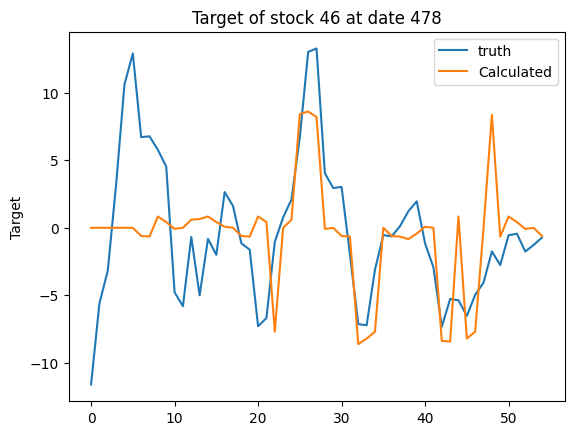

Mean absolute error : 3.619015599172053


In [355]:
excelfilereader=pd.read_csv(r'/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
data_sub=excelfilereader[excelfilereader['stock_id']==stock]
data_sub2=data_sub[data_sub['revealed_date_id']==date]
data=pd.DataFrame(data_sub2,columns=['revealed_target'])
data = data.values.tolist()
data=np.squeeze(data)
#print(data)

plt.plot(data,label="truth")
plt.plot(target_out,label="Calculated")
plt.ylabel('Target')
plt.title('Target of stock {} at date {}'.format(stock,date))
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error as mae
error = mae(data, target_out) 

print("Mean absolute error : " + str(error)) 

In [356]:
#agent.rlplot("Training Progress: stock {} date {}".format(int(stock),int(date)))

In [357]:
#env.reset()
#z = agent.view()

#df = pd.DataFrame(z)
#df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
#df['lastmarket']+=1
#df['newmarket']+=1
#df['short'] = np.nan
#df.loc[df['action']==0, 'short'] = df['newmarket']
#df['flat'] = np.nan
#df.loc[df['action']==1, 'flat'] = df['newmarket']
#df['long'] = np.nan
#df.loc[df['action']==2, 'long'] = df['newmarket']
#df['totalreward'] = df['reward'].cumsum()
#df.to_csv('df.csv')
#df

In [358]:
#def tradesim_chart(df, title="Trading Simulation"):

#    fig = go.Figure()
#    markersize=4

    # x axis
#    x = df['timestep']

#    red = 'rgba(192, 32, 32, 0.75)'
#    blue = 'rgba(32, 32, 192, 0.75)'
#    green = 'rgba(0, 204, 0, 0.75)'
#    black = 'rgba(32, 32, 32, 0.75)'

#    fig = make_subplots(specs=[[{"secondary_y": True}]])

#    fig.add_trace(go.Scatter(y=df['short'],
#                             x=x,
#                             name='Short (left axis)',
#                             mode='markers',
#                             marker=dict(size=markersize,
#                                         color=red),
#                            ),
 #                 secondary_y=False,
 #                )

  #  fig.add_trace(go.Scatter(y=df['flat'],
  #                           x=x,
  #                           name='Flat (left axis)',
  #                           mode='markers',
  #                           marker=dict(size=markersize,
  #                                       color=blue),
  #                          ),
  #                secondary_y=False,
  #               )

  #  fig.add_trace(go.Scatter(y=df['long'],
#                          x=x,
#                             name='Long (left axis)',
#                             mode='markers',
#                             marker=dict(size=markersize,
#                                         color=green),
#                            ),
#                  secondary_y=False,
#                 )

 #   fig.add_trace(go.Scatter(y=df['totalreward'],
 #                            x=x,
 #                            name='Total reward (right)',
  #                           mode='markers',
  #                           marker=dict(size=markersize,
  #                                       color=black),
  #                          ),
  #                secondary_y=True,
  #               )

    # plot attributes
  #  fig.update_layout(
  #      title= dict(text=title,
  #                  x=0.5,
  #                  xanchor='center'),
  #      xaxis=dict(
  #          title="Timesteps",
  #          linecolor='black',
  #          linewidth=1,
  #          mirror=True
  #      ),
  #      yaxis=dict(
  #          title="Price",
  #          linecolor='black',
  #          linewidth=1,
  #          mirror=True
  #      ),
  #      showlegend=True,
  #      legend=dict(x=0.738, y=0.05)
  #  )

  #  fig.update_yaxes(title_text="Total reward", secondary_y=True)

  #  fig.show()

In [359]:
#tradesim_chart(df, title="Trading stock {} date {}".format(int(stock),int(date)))

In [360]:
#prob=agent.predict_model.predict(agent.state_memory)
#print(prob)
#action = np.random.choice(agent.action_space, p=prob[0])
#print(action)
#action
#arr=np.array(df_new['stock'][index_pick])
#mean_diff=np.mean(np.absolute(np.diff(arr)))
#action_arr=np.array(df['action']-1)
#print(action_arr)
#pick=np.array(df_new['stock'][index_pick])
#wap_future=[]
#assume the first stock i
#wap_future.append(pick[0])
#for i in range(len(action_arr)):
#    wap_future.append(action_arr[i]*mean_diff+pick[i+1])
#index=[1,2,3,4,5,6,7,8,9]
#wap_future.append((action-1)*mean_diff+pick[-1])
#plt.plot(pick,"*",label="truth")
#plt.plot(index,wap_future,"*",label="prediction")
#plt.legend()
#plt.show()

In [361]:
#def shm_market_gen():
#    return market_gen(gen=user_sub(df_index,index_pick,start_trend=amplifier),
#                      lag=lag)

#env = Market(shm_market_gen,
#             lag=lag,
#             nstocks=1,
#             episode_length=ticks_per_episode)

#agent = REINFORCE_Agent(state_size=nstocks*lag*2,
#                        action_size=3,
#                       )
#agent.reset()
#start_time = time.time()
#print("Start: %s" % (time.strftime("%H:%M:%S")))

#for e in range(N_EPISODES):
#    agent.run_episode()
#    agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

#elapsed_time = time.time() - start_time
#print("\nTrain time: ", elapsed_time)

In [362]:
#agent.rlplot("Training Progress: Index date {}".format(int(date)))

In [363]:
#prob=agent.predict_model.predict(agent.state_memory)
#print(prob)
#action = np.random.choice(agent.action_space, p=prob[0])
#print(action)
#action
#arr=np.array(df_index['stock'][index_pick])
#mean_diff=np.mean(np.absolute(np.diff(arr)))
#print(np.mean(np.absolute(np.diff(arr))))
#action_arr=np.array(df['action']-1)
#print(action_arr)
#pick_index=np.array(df_index['stock'][index_pick])
#wap_future_index=[]
#assume in the first time index of t+60 the same as t
#wap_future_index.append(pick_index[0])
#for i in range(len(action_arr)):
#    wap_future_index.append(action_arr[i]*mean_diff+pick_index[i+1])
#index=[1,2,3,4,5,6,7,8,9]
#wap_future_index.append((action-1)*mean_diff+pick_index[-1])
#plt.plot(pick_index,"*",label="truth")
#plt.plot(index,wap_future_index,"*",label="prediction")
#plt.legend()
#plt.show()

In [364]:
#def target():
#    target_out=[]
#    for i in range(len(index_pick)):
#        target_out.append((wap_future[i]/pick[i]-wap_future_index[i]/pick_index[i])*10000)
#    return target_out

#seconds_in_bucket=[i * 10 for i in index_pick]
#comb=list(zip(seconds_in_bucket,target()))
#print("day=",date,"Stock=",stock,"seconds_in_bucket", seconds_in_bucket, target())
#print(comb)        
#sorted_zipped = sorted(comb, key=lambda x: x[0])    
#sorted_list1, sorted_list2 = zip(*sorted_zipped)
#print(list(sorted_list1))
#print(list(sorted_list2))

In [365]:
#env = Market(shm_market_gen,
#             lag=lag,
#             nstocks=1,
#             episode_length=ticks_per_episode)
#env.reset()

In [366]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()
counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    stock=test['stock_id']
    date=test['date_id']
    amplifier=1000
    df_new=Data_input(test,stock,date,amplifier)
    result_index=[]
    df_index=Index_Calc(test,date)
    for i in range(len(index_list)):
        ticks_per_episode = len(index_list[i])/dt-1-lag
        def shm_market_gen():
            return market_gen(gen=user_sub(df_index,index_list[i],start_trend=amplifier),lag=1)
        env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

        agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

        start_time = time.time()
        print("Start: %s" % (time.strftime("%H:%M:%S")))

        for e in range(N_EPISODES):
            agent.run_episode()
            agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

        elapsed_time = time.time() - start_time
        print("\nTrain time: ", elapsed_time)
        env.reset()
        z = agent.view()

        df = pd.DataFrame(z)
        df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
        df['lastmarket']+=1
        df['newmarket']+=1
        df['short'] = np.nan
        df.loc[df['action']==0, 'short'] = df['newmarket']
        df['flat'] = np.nan
        df.loc[df['action']==1, 'flat'] = df['newmarket']
        df['long'] = np.nan
        df.loc[df['action']==2, 'long'] = df['newmarket']
        df['totalreward'] = df['reward'].cumsum()
        df.to_csv('df_index_list_{}.csv'.format(i))
        prob=agent.predict_model.predict(agent.state_memory)
        action = np.random.choice(agent.action_space, p=prob[0])
        arr=np.array(df_index['stock'][index_list[i]])
        mean_diff=np.mean(np.absolute(np.diff(arr)))
        action_arr=np.array(df['action']-1)
        pick_index=np.array(df_index['stock'][index_list[i]])
        wap_future_index=[]
    #assume in the first time index of t+60 the same as t
        wap_future_index.append(pick_index[0])
        for j in range(len(action_arr)):
            wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
        wap_future_index.append((action-1)*mean_diff+pick_index[-1])
        seconds_in_bucket=[j * 10 for j in index_list[i]]
        comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
        result_index.append(comb)
    result_indx_list = list(chain.from_iterable(result_index))

    sorted_indx_result = sorted(result_indx_list, key=lambda x: x[0])

    seconds_in_bucket, wap_index, wap_index_future = zip(*sorted_indx_result)

    wap_index_list=list(wap_index)
    wap_index_future_list=list(wap_index_future)
    
    result=[]

    for i in range(len(index_list)):
        ticks_per_episode = len(index_list[i])/dt-1-lag
        def shm_market_gen():
            return market_gen(gen=user_sub(df_new,index_list[i],start_trend=amplifier),
                      lag=1)

        env = Market(shm_market_gen,
             lag=lag,
             nstocks=1,
             episode_length=ticks_per_episode)

        agent = REINFORCE_Agent(state_size=nstocks*lag*2,
                        action_size=3,
                       )

        start_time = time.time()
        print("Start: %s" % (time.strftime("%H:%M:%S")))

        for e in range(N_EPISODES):
            agent.run_episode()
            agent.score_episode(e, N_EPISODES)
    

    #if e and (e+1) % agent.save_interval == 0:
    #    agent.save()

        elapsed_time = time.time() - start_time
        print("\nTrain time: ", elapsed_time)
        env.reset()
        z = agent.view()

        df = pd.DataFrame(z)
        df.columns = ["timestep", "action", "lastmarket", "newmarket", "reward"]
        df['lastmarket']+=1
        df['newmarket']+=1
        df['short'] = np.nan
        df.loc[df['action']==0, 'short'] = df['newmarket']
        df['flat'] = np.nan
        df.loc[df['action']==1, 'flat'] = df['newmarket']
        df['long'] = np.nan
        df.loc[df['action']==2, 'long'] = df['newmarket']
        df['totalreward'] = df['reward'].cumsum()
        df.to_csv('df_list_{}.csv'.format(i))
        prob=agent.predict_model.predict(agent.state_memory)
        action = np.random.choice(agent.action_space, p=prob[0])
        pick_index=np.array(df_new['stock'][index_list[i]])
        mean_diff=np.mean(np.absolute(np.diff(arr)))
        action_arr=np.array(df['action']-1)
    #pick_index=np.array(df_new['stock'][index_list[i]])
        wap_future_index=[]
    #assume in the first time index of t+60 the same as t
        wap_future_index.append(pick_index[0])
        for j in range(len(action_arr)):
            wap_future_index.append(action_arr[j]*mean_diff+pick_index[j+1])
        wap_future_index.append((action-1)*mean_diff+pick_index[-1])
        seconds_in_bucket=[j * 10 for j in index_list[i]]
        comb=list(zip(seconds_in_bucket,pick_index,wap_future_index))
        result.append(comb)
    result_list = list(chain.from_iterable(result))
    sorted_result = sorted(result_list, key=lambda x: x[0])
    seconds_in_bucket, wap, wap_future = zip(*sorted_result)
    seconds_in_bucket_list=list(seconds_in_bucket)
    wap_list=list(wap)
    wap_future_list=list(wap_future)

    target_out=[]
    for i in range(len(seconds_in_bucket_list)):
        target_out.append((wap_future_list[i]/wap_list[i]-wap_index_future_list[i]/wap_index_list[i])*10000)


    
    sample_prediction['target'] = target_out
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
